# Pre-process

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [13]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
#Read corpus
corpus = open('./data/corpus', 'r').read()
# Tokenização
words = word_tokenize(corpus)

# Obtendo a lista de stopwords para o inglês
stop_words = set(stopwords.words('english'))

# Removendo stopwords
filtered_words = [word for word in words if word.lower() not in stop_words]

#
size_of_sentence = 20
sentences = [filtered_words[i:i+size_of_sentence] for i in range(0, len(filtered_words), size_of_sentence)]



In [15]:
#Read analogy
f = open("data/questions-words.txt", "r")

# Experimentações

In [16]:
import random
import numpy as np
from gensim.models import Word2Vec

random.seed(42)

# Assuming `sentences` and `f` are already defined.
rows = f.read().split('\n')
rows = rows[1:]



In [17]:
# Hyperparameter grid
hyperparam_grid = {
    'epochs': [10, 20, 30],
    'vector_size': [50, 100, 200],
    'window': [5, 10, 15],
    'min_count': [1, 2, 3],
    'sg': [0, 1]  # 0 for CBOW, 1 for Skip-gram
}

In [18]:
import random
from numpy.linalg import norm

random.seed(42)


def inference(model):
    hits = 0
    wrong = 0
    not_found = 0
    distances = []  # list to store distances

    for i, row in enumerate(rows):
        word_list = row.split(' ')
        context_words = [word.lower() for word in word_list]

        if len(context_words) == 4:
            p1, c1, p2, c2 = context_words
            
            random_word = random.choice([p1, c1, p2, c2])

            try:

                if random_word == p1:
                    result_vector = model.wv[c2] - model.wv[c1] + model.wv[p2]
                elif random_word == c1:
                    result_vector = model.wv[p1] - model.wv[p2] + model.wv[c2]
                elif random_word == p2:
                    result_vector = model.wv[c1] - model.wv[c2] + model.wv[p1]
                elif random_word == c2:
                    result_vector = model.wv[p1] - model.wv[p2] + model.wv[c1]

                predicted_words = model.wv.most_similar(positive=[result_vector], topn=10, restrict_vocab=None)
                predicted_word = next((word for word, score in predicted_words if word not in word_list), None)

                if predicted_word:
                    # Compute Euclidean distance
                    distance = norm(model.wv[predicted_word] - model.wv[random_word])
                    distances.append(distance)

                    if predicted_word == random_word:
                        hits += 1
                    else:
                        wrong += 1
            except KeyError:
                not_found += 1

    avg_distance = sum(distances) / len(distances) if distances else 0
    return hits, wrong, not_found, avg_distance



In [19]:
# Function to train and evaluate a model
def train_and_evaluate(params, sentences):
    model = Word2Vec(sentences, vector_size=params['vector_size'], window=params['window'], 
                     min_count=params['min_count'], workers=4, sg=params['sg'])
    model.train(sentences, total_examples=len(sentences), epochs=params['epochs'])
    
    hits, wrong, not_found, avg_distance = inference(model)
    if (hits + wrong) == 0:
        score = 0
    else:
        score = hits / (hits + wrong)  # This computes accuracy. You can change it according to your requirements.
    
    print(f"Score: {score}, Hits: {hits}, Wrong: {wrong}, Not found: {not_found}, Avg. distance: {avg_distance}")
    return score, hits, wrong, not_found, avg_distance


In [20]:
# Run experiments
results = {}
for epochs in hyperparam_grid['epochs']:
    for vector_size in hyperparam_grid['vector_size']:
        for window in hyperparam_grid['window']:
            for min_count in hyperparam_grid['min_count']:
                for sg in hyperparam_grid['sg']:
                    params = {
                        'epochs': epochs,
                        'vector_size': vector_size,
                        'window': window,
                        'min_count': min_count,
                        'sg': sg,
                        'model_type': 'CBOW' if sg == 0 else 'Skip-gram'
                    }
                    print(f"Training model with parameters: {params}")
                    score, hits, wrong, not_found, avg_distance = train_and_evaluate(params, sentences)
                    results[str(params)] = {
                        'score': score,
                        'hits': hits,
                        'wrong': wrong,
                        'not_found': not_found,
                        'avg_distance': avg_distance 
                    }


Training model with parameters: {'epochs': 10, 'vector_size': 50, 'window': 5, 'min_count': 1, 'sg': 0, 'model_type': 'CBOW'}
Score: 0.011798941798941798, Hits: 223, Wrong: 18677, Not found: 644, Avg. distance: 11.045154072118814
Training model with parameters: {'epochs': 10, 'vector_size': 50, 'window': 5, 'min_count': 1, 'sg': 1, 'model_type': 'Skip-gram'}
Score: 0.016984126984126983, Hits: 321, Wrong: 18579, Not found: 644, Avg. distance: 3.308664150310572
Training model with parameters: {'epochs': 10, 'vector_size': 50, 'window': 5, 'min_count': 2, 'sg': 0, 'model_type': 'CBOW'}
Score: 0.01034315573991273, Hits: 192, Wrong: 18371, Not found: 981, Avg. distance: 10.876848097981124
Training model with parameters: {'epochs': 10, 'vector_size': 50, 'window': 5, 'min_count': 2, 'sg': 1, 'model_type': 'Skip-gram'}
Score: 0.018854710984215914, Hits: 350, Wrong: 18213, Not found: 981, Avg. distance: 3.1971228828090075
Training model with parameters: {'epochs': 10, 'vector_size': 50, 'windo

In [35]:
import pandas as pd
import ast

def results_to_dataframe(results):
    # Transformando as chaves (strings) de volta para dicionários
    param_dicts = [ast.literal_eval(key) for key in results.keys()]
    
    # Extraindo os valores correspondentes
    values = list(results.values())
    
    # Juntando os parâmetros e os valores em uma única lista de dicionários
    merged_dicts = []
    for p, v in zip(param_dicts, values):
        merged_dict = {**p, **v}
        merged_dicts.append(merged_dict)
    
    # Convertendo a lista de dicionários para um DataFrame
    df = pd.DataFrame(merged_dicts)
    
    return df

# Uso da função
df_results = results_to_dataframe(results)

# Mostrando o DataFrame (opcional)
print(df_results)


df_results.to_csv('results.csv', index=False)

     epochs  vector_size  window  min_count  sg model_type     score  hits  \
0        10           50       5          1   0       CBOW  0.011799   223   
1        10           50       5          1   1  Skip-gram  0.016984   321   
2        10           50       5          2   0       CBOW  0.010343   192   
3        10           50       5          2   1  Skip-gram  0.018855   350   
4        10           50       5          3   0       CBOW  0.012800   231   
..      ...          ...     ...        ...  ..        ...       ...   ...   
157      30          200      15          1   1  Skip-gram  0.003122    59   
158      30          200      15          2   0       CBOW  0.000754    14   
159      30          200      15          2   1  Skip-gram  0.002963    55   
160      30          200      15          3   0       CBOW  0.000388     7   
161      30          200      15          3   1  Skip-gram  0.003657    66   

     wrong  not_found  avg_distance  
0    18677        644    

# Analisys

In [5]:
import pandas as pd
df_results = pd.read_csv('results.csv')

In [11]:
top_5_scores.head(5)

,epochs,vector_size,window,min_count,sg,model_type,score,hits,wrong,not_found,avg_distance
11,10,50,10,3,1,Skip-gram,0.020945,378,17669,1497,3.089711
7,10,50,10,1,1,Skip-gram,0.020899,395,18505,644,3.273461
15,10,50,15,2,1,Skip-gram,0.020148,374,18189,981,3.130309
59,20,50,5,3,1,Skip-gram,0.020003,361,17686,1497,3.288157
5,10,50,5,3,1,Skip-gram,0.019948,360,17687,1497,3.131827


In [10]:
top_5_scores = df_results.nlargest(5, 'score')
top_5_scores[['score', 'model_type', 'epochs', 'vector_size', 'window', 'min_count', 'sg']]

,score,model_type,epochs,vector_size,window,min_count,sg
11,0.020945,Skip-gram,10,50,10,3,1
7,0.020899,Skip-gram,10,50,10,1,1
15,0.020148,Skip-gram,10,50,15,2,1
59,0.020003,Skip-gram,20,50,5,3,1
5,0.019948,Skip-gram,10,50,5,3,1


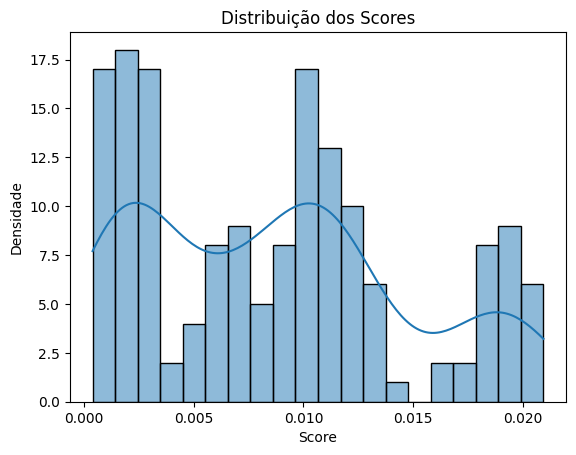

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_results['score'], bins=20, kde=True)
plt.title('Distribuição dos Scores')
plt.xlabel('Score')
plt.ylabel('Densidade')
plt.show()


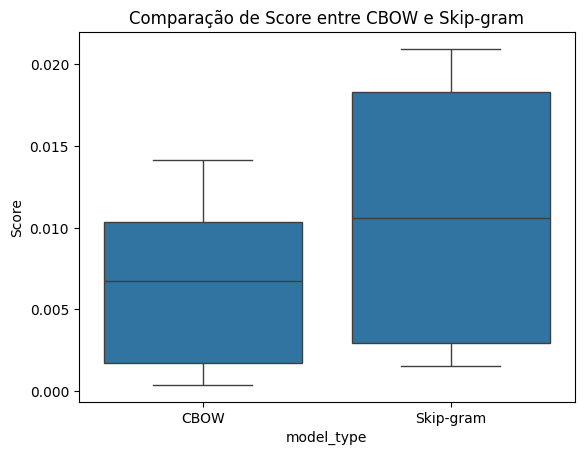

In [45]:
sns.boxplot(x='model_type', y='score', data=df_results)
plt.title('Comparação de Score entre CBOW e Skip-gram')
plt.ylabel('Score')
plt.show()


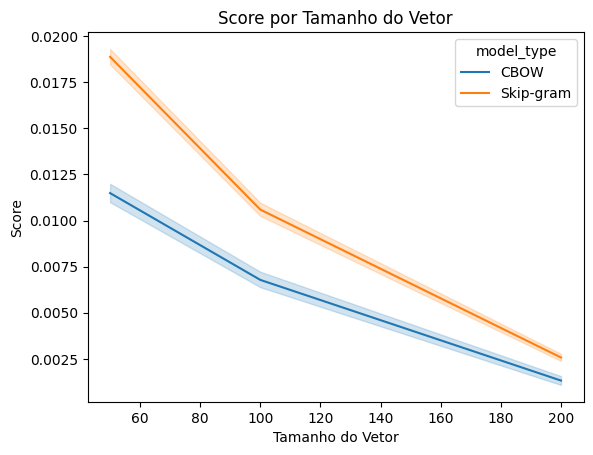

In [46]:
sns.lineplot(x='vector_size', y='score', hue='model_type', data=df_results)
plt.title('Score por Tamanho do Vetor')
plt.ylabel('Score')
plt.xlabel('Tamanho do Vetor')
plt.show()


Text(0.5, 0, 'Window Size')

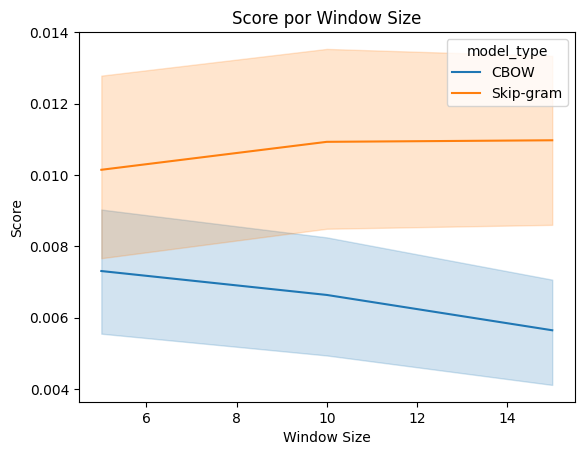

In [12]:
#Score por window size
sns.lineplot(x='window', y='score', hue='model_type', data=df_results)
plt.title('Score por Window Size')
plt.ylabel('Score')
plt.xlabel('Window Size')


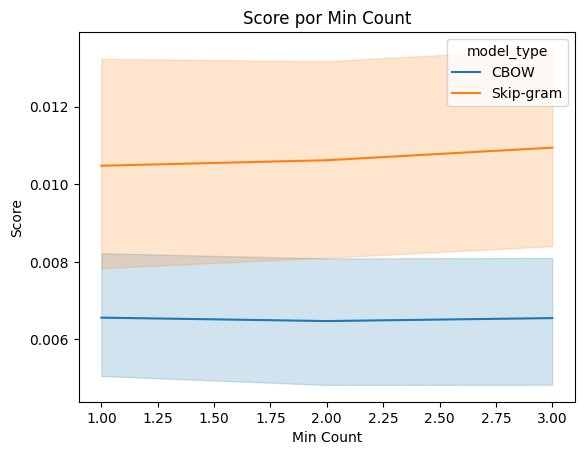

In [13]:
#score por min_count
sns.lineplot(x='min_count', y='score', hue='model_type', data=df_results)
plt.title('Score por Min Count')
plt.ylabel('Score')
plt.xlabel('Min Count')
plt.show()


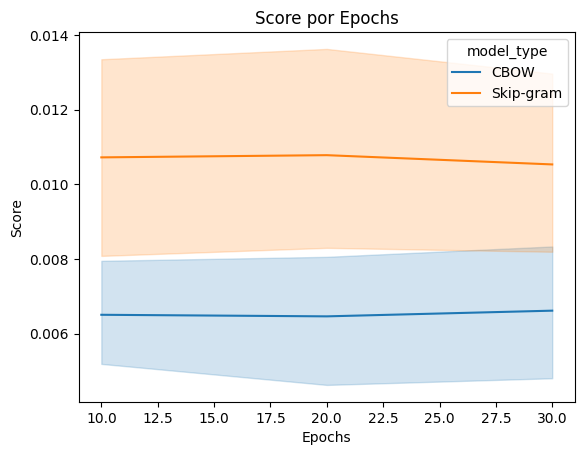

In [14]:
#score por epochs
sns.lineplot(x='epochs', y='score', hue='model_type', data=df_results)
plt.title('Score por Epochs')
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.show()